In [23]:
%matplotlib inline

In [2]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from nltk.corpus import stopwords

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [30]:
df = pd.read_csv('.\messages.csv').dropna()
df['time'] = df["time"].astype("datetime64")
df.head()

,sender_name,time,content
0,Marcin Zimmer,2018-07-19 10:21:18,Marcin: 󰀀
1,Bartosz Jakubowski,2018-07-19 10:12:26,Obsługa muzyczna wydarzenia.
2,Marcin Zimmer,2018-07-19 10:04:48,Jak chcesz ja miec zatytulowana?
3,Kamila Bilicka,2018-07-19 09:39:04,Kamila: 󰀀
4,Bartosz Jakubowski,2018-07-19 09:33:01,Marcin/Kama wystawcie mi prosze fakture na: Gr...


In [99]:
# df = df[df['time'] > '2018-01-01']
my_name = 'Mateusz Dorobek'
my_df = df[df['sender_name'] == my_name]
len(my_df)

71599

In [15]:
my_df.head()

,sender_name,time,content
5,Mateusz Dorobek,2018-07-19 09:28:47,Ja nie mam
31,Mateusz Dorobek,2018-07-14 17:19:53,G. G. G. Amol A A
99,Mateusz Dorobek,2017-07-14 22:20:19,Trzeba się przejść na jam session kiedyś
100,Mateusz Dorobek,2017-07-14 22:20:04,Fajnie
101,Mateusz Dorobek,2017-07-10 17:35:43,dobra ziom lece na próbę jak coś to dzwoń


In [16]:
def analyse_xd(df):
    pattern = r'([xX]+[dD]+)'
    content = df['content']
    xds = df['content'].str.extractall(pattern)# .unstack() #.apply(','.join, 1)
    xds = xds.reset_index(drop=True)[0]
    return xds.value_counts(), xds.apply(lambda x: len(x)).mean()


def analyse_xd_via_time(df):
    df = df.copy()
    pattern = r'([xX]+[dD]+)'
    content = df['content']
    xds = df['content'].str.extractall(pattern)# .unstack() #.apply(','.join, 1)
    
    l = []
    indices = [i[0] for i in xds.index.values]
    for i, _ in tqdm(df.iterrows(), total=len(df)):
        if i in indices:
            l.append(1)
        else:
            l.append(0)
            
    df['xd'] = l
    df = df[['time', 'xd']]
    return df.groupby(df["time"].dt.hour).sum()

In [17]:
from collections import Counter

def most_common_words(df, n=-1):
    to_delete = ['wysłałeś', 'zdjęcie', '']
    stop = stopwords.words('polish')
    c = Counter()
    
    def update_counter(msg):
        msg = msg.lower().translate(str.maketrans('', '' , ',."\'?!')).split(' ')
        c.update(msg)
        
    df['content'].apply(update_counter)
    
    for drop_w in itertools.chain(stop, to_delete):
            c.pop(drop_w, None)
    
    for k in list(c.keys()):
            if k.isnumeric():
                c.pop(k, None)
    
    return c if n == -1 else c.most_common(n)
    

In [18]:
def average_msg_len(df):
    lengths = df['content'].apply(lambda x: len(x))
    return lengths

In [19]:
def msg_per_hour(df):
    return df['time'].groupby(df["time"].dt.hour).count()

def msg_per_day(df):
    mapping = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    weekdays = df['time'].apply(lambda x: mapping[x.weekday()])
    return weekdays.value_counts()

In [20]:
def swear_percent(df, swear_list):
    emotes = ['xd', 'xdd', 'xddd', ':)', ':(', ':c', '<3', ';)', ';(', ';c', ';*', ':*', '^^', ';>', ':>', 
              ';<', ':<', ':d', ';d', ':p', ';p', ';]', ':]', ';[', ':[', '-.-' '^.^', '*.*',
              ':\\', ';\\', ':/', ';/', ':-)', ';-)', ':-/', ';-/']
    
    c = most_common_words(df)
    for emote in emotes:
        c.pop(emote, None)
              
    swears, total = 0, sum(c.values())
    for swear in swear_list:
        if swear in c:
            swears += c[swear]
    return swears / total

In [21]:
with open('wulgaryzmy.txt') as f:
    swear_list = f.read().split(' ')

swear_percent(my_df, swear_list)

0.0053440309810011315

#### Rozkład wysyłanych wiadomości godzinowo

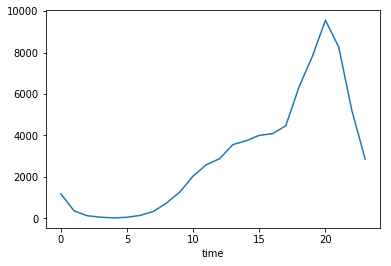

In [24]:
hist_hour = msg_per_hour(my_df)
hist_hour.plot()

#### Rozkład wysyłanych wiadomości dziennie

<class 'pandas.core.series.Series'>


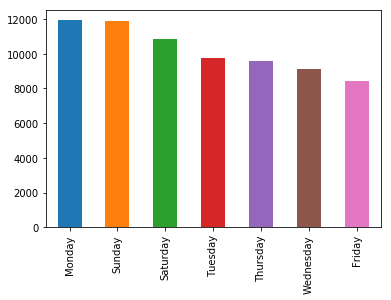

In [25]:
weekdays = msg_per_day(my_df)
print(weekdays.__class__)
weekdays.plot(kind='bar')

#### Najczęstsze rodzaje wysyłanego xD

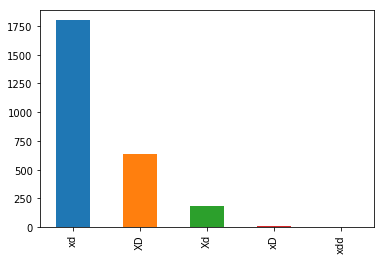

In [26]:
xds_counts, mean_xd_len = analyse_xd(my_df)
xds_counts[:5].plot(kind='bar')

#### ilość XD per godzina

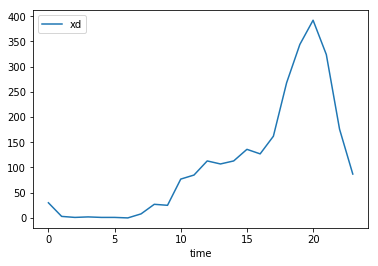

In [27]:
xd_time = analyse_xd_via_time(my_df)
xd_time.plot()

#### Najczęściej występujące słowa

In [28]:
mcw = most_common_words(my_df, n=50)
for w, c in mcw:
    print(f'{w}\t\t{c}')

xd		2568
dobra		1917
wiem		1440
spoko		1437
hej		1264
masz		1075
ok		1038
jutro		867
chyba		747
jakieś		676
pewnie		596
mogę		556
dzięki		539
ty:		524
󰀀		524
bym		518
=		487
trochę		477
chcesz		456
zrobić		423
możesz		414
załącznik		397
-		395
daj		394
wiesz		387
później		380
link		368
nom		355
siema		355
fajnie		354
chce		354
wogóle		346
miał		335
kurwa		332
wysłałeś(aś)		332
narazie		319
grać		316
;p		305
mamy		300
<a		294
napisz		291
lepiej		286
zaraz		283
;)		280
stary		274
ogarnąć		270
raczej		266
elo		260
robić		258
dzieki		254


#### Średnia długość wiadomości (w znakach) - wyrzucone outliery

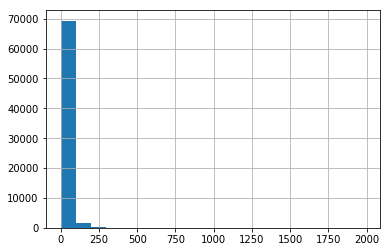

In [42]:
lengths = average_msg_len(my_df)
lengths[~((lengths-lengths.mean()).abs() > 3*lengths.std())].hist(bins=20)

**Ekstrakcja Danych do CSV-ek**

In [103]:
fav_words = pd.Series()
for w, c in mcw:
    fav_words = fav_words.set_value(w,c)

E:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
lengths[~((lengths-lengths.mean()).abs() > 0.3*lengths.std())].to_csv('extracted_data/lengths.csv', index=True)
fav_words.to_csv('extracted_data/fav_words.csv', index=True)
xds_counts.to_csv('extracted_data/xds_counts.csv', index=True)
weekdays.to_csv('extracted_data/weekdays.csv', index=True)
hist_hour.to_csv('extracted_data/hist_hour.csv', index=False)
xd_time.to_csv('extracted_data/xd_time.csv', index=False)

In [106]:
info = pd.Series()
info = info.set_value("name",my_name)
info = info.set_value("swear_percent",swear_percent(my_df, swear_list))
info = info.set_value("messeges_len",len(my_df))
print(info)
info.to_csv('extracted_data/info.csv', index=True)

E:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
E:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


name             Mateusz Dorobek
swear_percent         0.00534403
messeges_len               71599
dtype: object
